**<center>3F2 Lab Report<center>**

Name: <br>
Surname: <br>
CrsId: <br>
Apparatus #: <br>

In [2]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 8]

In [3]:
# Define the  physical constants for the pendulum experiment

g=9.81  # m/s^2
L=0.125 # distance from pendulum's centre of mass to pivot in m
a=0.016 # radius of pulley in m
m=0.32  # mass of pendulum in kg
M=0.7  # mass of carriage in kg
I=8e-5  # moment of inertia on motor shaft in kg m^2
km = 0.08  # torque motor constant in Nm/A
ka = -0.50 # amplifier constant in A/V

gamma =  M/m + I/(m*np.power(a,2))

#scale factors to get physical units metres radians and seconds.
#in the crane/down position
# [x xdot Ltheta Lthetadot]=[CP CV PP PV]*Sc where,
Sc=np.diag([-1/12.5, -1/2.23, L/3.18, L/0.64])

# in the inverted position
# [x xdot Lphi Lphidot]=[CP CV PP PV]*Sp where,
Sp=np.diag([-1/12.5, -1/2.23, L/3.18, -L/0.64])

#controller amplifier gains on each measurement
opamp_c = np.diag([-20,-30, 20, -10]) # for crane controller
opamp_p = np.diag([10,20,30,-20]) # for inverted pendulum controller

#maximum torque from the motor in Nm
Tmax=0.4

# squares of the natural frequencies
om12=g/L 
om02=om12*(1+1/gamma)

#linearized crane  model

Ac=np.array([[0, 1, 0, 0,], [0, 0, om12-om02, 0], [0, 0, 0, 1], [0, 0, -om02, 0]])
Cc=-(ka*km/(m*a*gamma))*np.linalg.solve(Sc,opamp_c)
B=np.array([[0],[1],[0],[1]])

#linearized inverted pendulum model
Ap=np.array([[0, 1, 0, 0], [0, 0, om02-om12, 0], [0, 0, 0, 1], [0, 0, om02, 0]])
Cp=-(ka*km/(m*a*gamma))*np.linalg.solve(Sp,opamp_p)

# Sampling period 
h=0.0025 #sampling period
h_sim=0.002 #simulation step size

Helper functions are defined here (you should not have to change these). Click to reveal and then click the vertical bar to rehide.

In [4]:
# Define helper functions

def solver_crane(x0,tsim,tdem,xdem,p):
  x = np.copy(x0)
  x_sim = x.reshape(1,4)
  T_sim = []
  if x0[2]>0.05:
      stopped=0
  else:
      stopped =1
    
  def next_state_crane(x):
    theta = x[2]/L
    sinth = np.sin(theta)
    costh = np.cos(theta)
    newx = np.empty(4) 
    nonlocal stopped
    if stopped==1 and (np.abs(T/a - m*g*sinth*costh - m/L*sinth*x[3]**2)< Fstatic):
        newx[0] = x[0]
        newx[1] = 0.0
        newx[2] = x[2]+ h_sim*x[3]+0.5*h_sim**2*(-g*sinth)
        sinth1 = np.sin(newx[2]/L)
        costh1 = np.cos(newx[2]/L)
        newx[3] = x[3] -h_sim*g*(sinth+sinth1)*0.5
    else:
         stopped=0
         x24dot =np.linalg.solve(np.array([[1+gamma,-costh],[-costh,1]]),np.array([-sinth/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinth]))    
         newx[[0,2]]=x[[0,2]]+h_sim*x[[1,3]]+0.5*(h_sim**2)*x24dot

         sinth1 = np.sin(newx[2]/L)
         costh1 = np.cos(newx[2]/L)
         x24dot1 = np.linalg.solve(np.array([[1+gamma,-costh1],[-costh1,1]]),np.array([-sinth1/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinth1]))    
         newx[[1,3]]=x[[1,3]]+h_sim*0.5*(x24dot+x24dot1)
         if((x[1]!=0.0) & (x[1]*newx[1]<=0.0)):
             stopped= 1
    return newx

  for t in tsim:
      xd = np.interp(t,tdem,xdem)
      T= (ka*km*P@ opamp_c@ np.linalg.solve(Sc,(x-np.array([xd,0,0,0]))))[0]
      if np.abs(T)>Tmax:
          T= Tmax*np.sign(T)
      T_sim.append(T.item())
      x = next_state_crane(x)
      x_sim = np.vstack((x_sim,np.transpose(x)))
  return x_sim
# Define helper functions

def solver_pendulum(x0,tsim,tdem,xdem,p):
  x = np.copy(x0)
  x_sim = x.reshape(1,4)
  T_sim = []
  if x0[2]>0.05:
      stopped=0
  else:
      stopped =1

  def next_state_pendulum(x):
    phi = x[2]/L
    sinphi = np.sin(phi)
    cosphi = np.cos(phi)
    newx = np.empty(4) 
    nonlocal stopped
    if stopped==1 and (np.abs(T/a + m*g*sinphi*cosphi - m/L*sinphi*newx[3]**2)< Fstatic): #x[3]
        newx[0] = x[0]
        newx[1] = 0.0
        newx[2] = x[2]+ h_sim*x[3]+0.5*h_sim**2*(g*sinphi)
        sinphi1 = np.sin(newx[2]/L)
        cosphi1 = np.cos(newx[2]/L)
        newx[3] = x[3] +h_sim*g*(sinphi+sinphi1)*0.5
    else:
         stopped=0
         x24dot =np.linalg.solve(np.array([[1+gamma,-cosphi],[cosphi,-1]]),np.array([-sinphi/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinphi]))    
         newx[[0,2]]=x[[0,2]]+h_sim*x[[1,3]]+0.5*(h_sim**2)*x24dot

         sinphi1 = np.sin(newx[2]/L)
         cosphi1 = np.cos(newx[2]/L)
         x24dot1 = np.linalg.solve(np.array([[1+gamma,-cosphi1],[cosphi1,-1]]),np.array([-sinphi1/L*x[3]**2 + T/(m*a)-(F/m)*np.sign(x[1]),-g*sinphi1]))    
         newx[[1,3]]=x[[1,3]]+h_sim*0.5*(x24dot+x24dot1)
         if((x[1]!=0.0) & (x[1]*newx[1]<=0.0)):
             stopped= 1
    return newx

  for t in tsim:
      xd = np.interp(t,tdem,xdem)
      T= (ka*km*P@ opamp_p@ np.linalg.solve(Sp,(x-np.array([xd,0,0,0]))))[0]
      if np.abs(T)>Tmax:
          T= Tmax*np.sign(T)
      T_sim.append(T.item())
      x = next_state_pendulum(x)
      x_sim = np.vstack((x_sim,np.transpose(x)))
  return x_sim

def loadlogdata(n,ScaleF):

  if n> 9:
    filename = 'Plot 0' + str(n) + '.csv'
  else:
    filename = 'Plot 00' + str(n)+ '.csv'

  LoadedDataCSV = np.genfromtxt(filename,delimiter=',',skip_header=16)
  # this seems to be sufficient if the offset for the header is always the same
  #print(LoadedDataCSV)
  #LoadedDataCSV = np.delete(LoadedDataCSV,-1,axis=1)
  #print(LoadedDataCSV)
  DataOfInterestCSV = np.array(LoadedDataCSV[:,[2,3,4,5,1]])
  # we now need to swap data so to place it in the following order
  # t CP CV PP PV CD
  # from an orginal order of: 
  # t CD CP CV PP PV
  logdataCSV = DataOfInterestCSV*20/4095-10
  logdataCSV[:,[1,2,3]] = -logdataCSV[:,[1,2,3]]
  xdata=np.concatenate([logdataCSV[:,0:4]@ScaleF, logdataCSV[:,-1:]*ScaleF[0,0]], axis=1)
  ###  
  xdem = xdata[:,-1]
  endtime=LoadedDataCSV[-1,0]
  t = np.linspace(0,endtime,xdata.shape[0])

  return xdata, xdem, t
 
def plot_function_crane(t0,tf,t,xdata,tsim,x_sim,p):
  ind = (t>=t0) & (t<=tf)
  plt.figure()
  plt.suptitle("Crane position with p = %s"%p, fontsize=15)

  plt.subplot(411)
  plt.plot(t[ind],xdata[ind,0], color='blue') #data
  plt.plot(tsim,x_sim[:-1,0], color='red',linestyle='--') #simulation
  plt.plot(t[ind],xdata[ind,-1], linestyle =':', color='green') # Demand
  plt.legend(['Measured','Simulated','Demand']);
  plt.ylabel("x[m]")

  plt.subplot(412)
  plt.plot(t[ind],xdata[ind,1], color='blue') #data
  plt.plot(tsim,x_sim[:-1,1], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']); 
  plt.ylabel("v[m/s]")

  plt.subplot(413)
  plt.plot(t[ind],xdata[ind,2], color='blue') #data
  plt.plot(tsim,x_sim[:-1,2], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$Theta$[m]")

  plt.subplot(414)
  plt.plot(t[ind],xdata[ind,3], color='blue') #data
  plt.plot(tsim,x_sim[:-1,3], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$omega$[m/s]")

  plt.xlabel("time [s]")

def plot_function_pendulum(t0,tf,t,xdata,tsim,x_sim,p):
  ind = (t>=t0) & (t<=tf)
  plt.figure()
  plt.suptitle("Pendulum position with p = %s"%p, fontsize=15)

  plt.subplot(411)
  plt.plot(t[ind],xdata[ind,0], color='blue') #data
  plt.plot(tsim,x_sim[:-1,0], color='red',linestyle='--') #simulation
  plt.plot(t[ind],xdata[ind,-1], linestyle =':', color='green') # Demand
  plt.legend(['Measured','Simulated','Demand']);
  plt.ylabel("x[m]")

  plt.subplot(412)
  plt.plot(t[ind],xdata[ind,1], color='blue') #data
  plt.plot(tsim,x_sim[:-1,1], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']); 
  plt.ylabel("v[m/s]")

  plt.subplot(413)
  plt.plot(t[ind],xdata[ind,2], color='blue') #data
  plt.plot(tsim,x_sim[:-1,2], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$/Theta$[m]")

  plt.subplot(414)
  plt.plot(t[ind],xdata[ind,3], color='blue') #data
  plt.plot(tsim,x_sim[:-1,3], color='red',linestyle='--') #simulation
  plt.legend(['Measured','Simulated']);
  plt.ylabel("L$omega$[m/s]")

  plt.xlabel("time [s]")

# 3) Crane mode

## 3.1) Friction measurement
Measure the dynamic and static friction

In [5]:
F = 1.0
Fstatic = 1.4   # Newton

## 3.3) Synthesis of the $p_3$ and $p_4$ controllers


In [6]:
P = np.array([[0.35,0.15,0.45,0.05]]);
print(np.linalg.eig(Ac-B@P@Cc)[0]) # Note that the [0] is there to ignore the second output of eig

[-8.2625171 +27.64244253j -8.2625171 -27.64244253j
 -0.96587796 +4.40876411j -0.96587796 -4.40876411j]


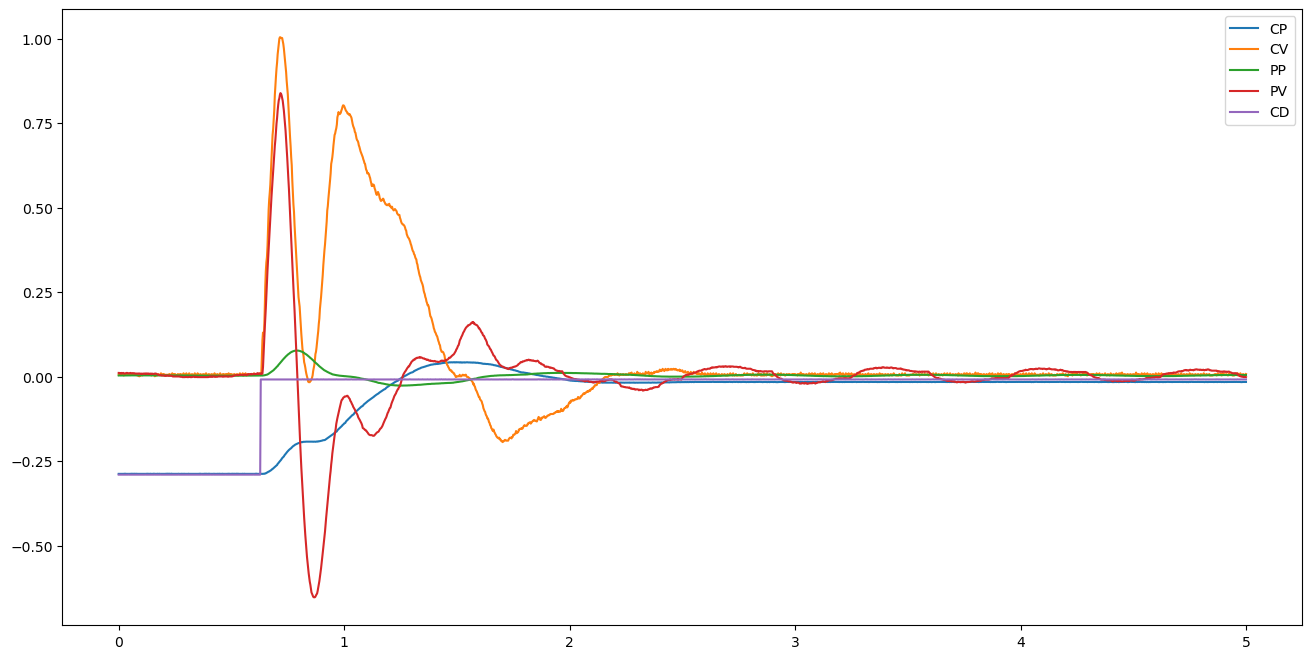

In [7]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(1,Sc)
# in the previous line xdem is the external input into the system.
plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

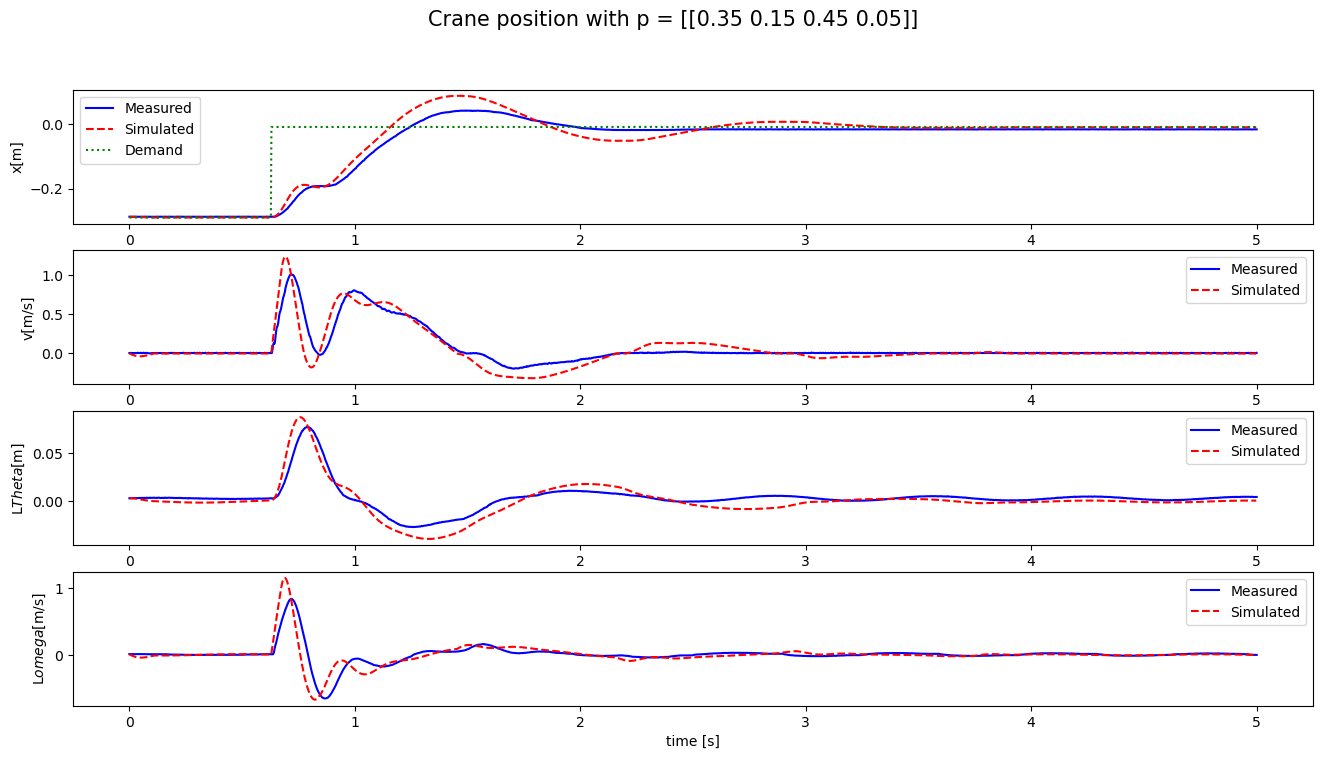

In [8]:
t0 = 0; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)

plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)

# Comment on the transient response and pole position

...

## 3.4) Pole-placement

### 3.4a)  
Use example 1 of section A.5 together with the scale factors of section A.7 to place all the closed-loop poles at $−\omega_1 = −\sqrt 78.5$. Record your calculated values of $p_1–p_4$

In [9]:
P = np.array([[0.13, 0.21, 0.23, 0]])
print("P:", P)
print(np.linalg.eig(Ac-B@P@Cc)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.13 0.21 0.23 0.  ]]
[-12.45360996+6.46216554j -12.45360996-6.46216554j
  -4.89083448+2.84116008j  -4.89083448-2.84116008j]


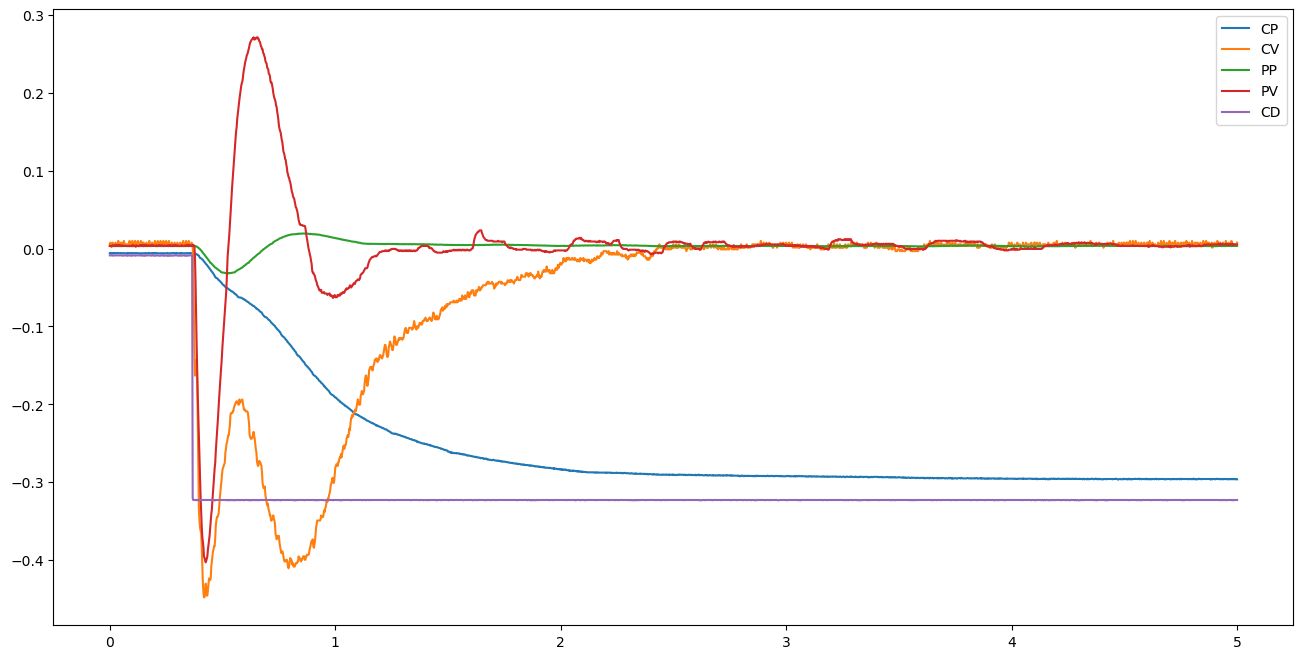

In [10]:
############################## LOAD DATA #######################################
xdata, xdem, tdata =loadlogdata(2,Sc)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

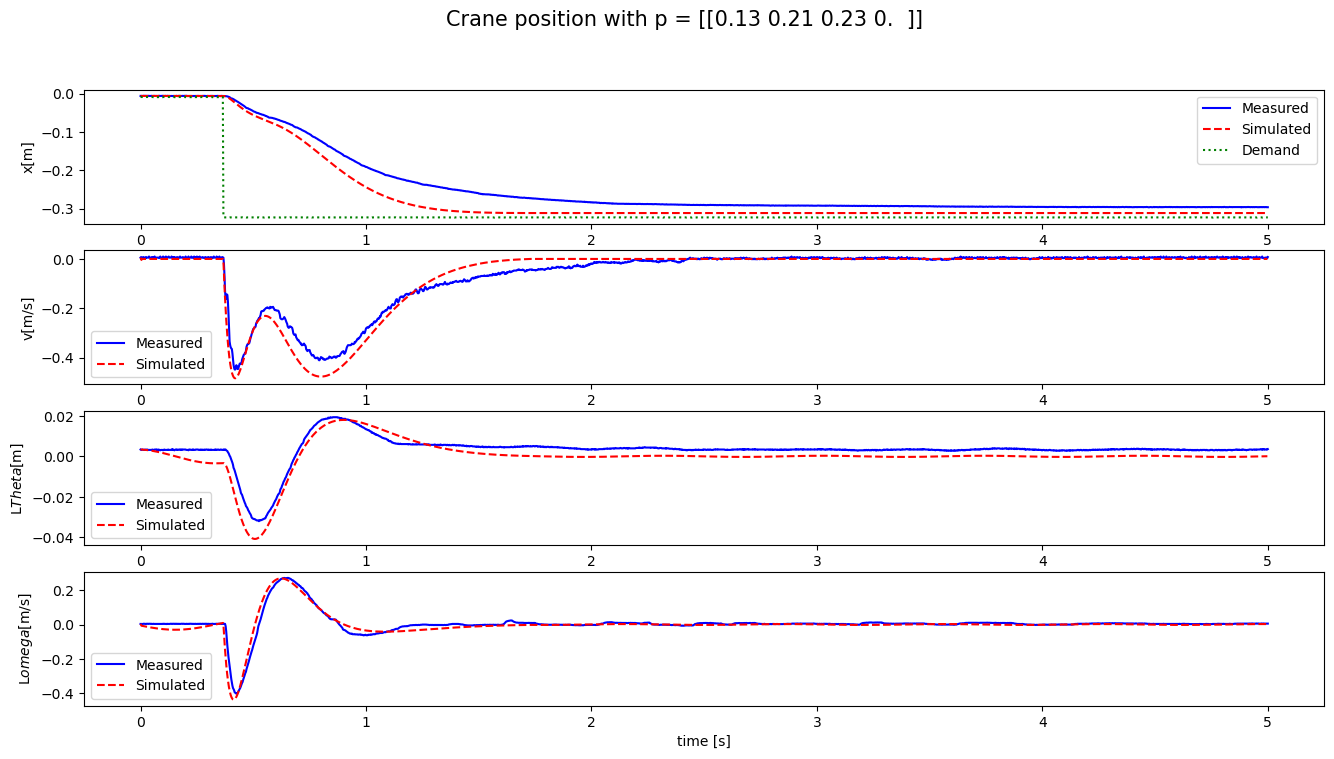

In [11]:
t0 = 0; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)

plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)


# Comment on the consistency with the target pole position

...

### 3.4b)  
Now increase the speed of response by placing the closed-loop poles at $-\alpha,-\beta,-\omega\pm j\omega$ for suitable values of $\alpha, \beta$ and $\omega$. Record your choice (of $\alpha, \beta$ and $\omega$) and the corresponding potentiometer settings. Log the step response and comment. *[It is not expected that you will choose the same values as any other student!]*.

In [12]:
alpha = 12; beta = 15;omega = 8
k = np.empty(4)
k[0]=2*omega**2*alpha*beta/om12
k[1]=(2*omega**2*(alpha+beta)+2*omega*alpha*beta)/om12
k[2]=2*omega**2+2*omega*(alpha+beta)+alpha*beta-om02-k[0]
k[3]=2*omega+alpha+beta-k[1] 
P=np.array([k/np.diag(Cc)])
print("alpha=", alpha, "beta=", beta, "omega =",omega)
print("P= ",P)
print(np.linalg.eig(Ac-B@P@Cc)[0]) 



alpha= 12 beta= 15 omega = 8
P=  [[0.47559633 0.4887481  0.27313498 0.2984814 ]]
[-12.+0.j -15.+0.j  -8.+8.j  -8.-8.j]


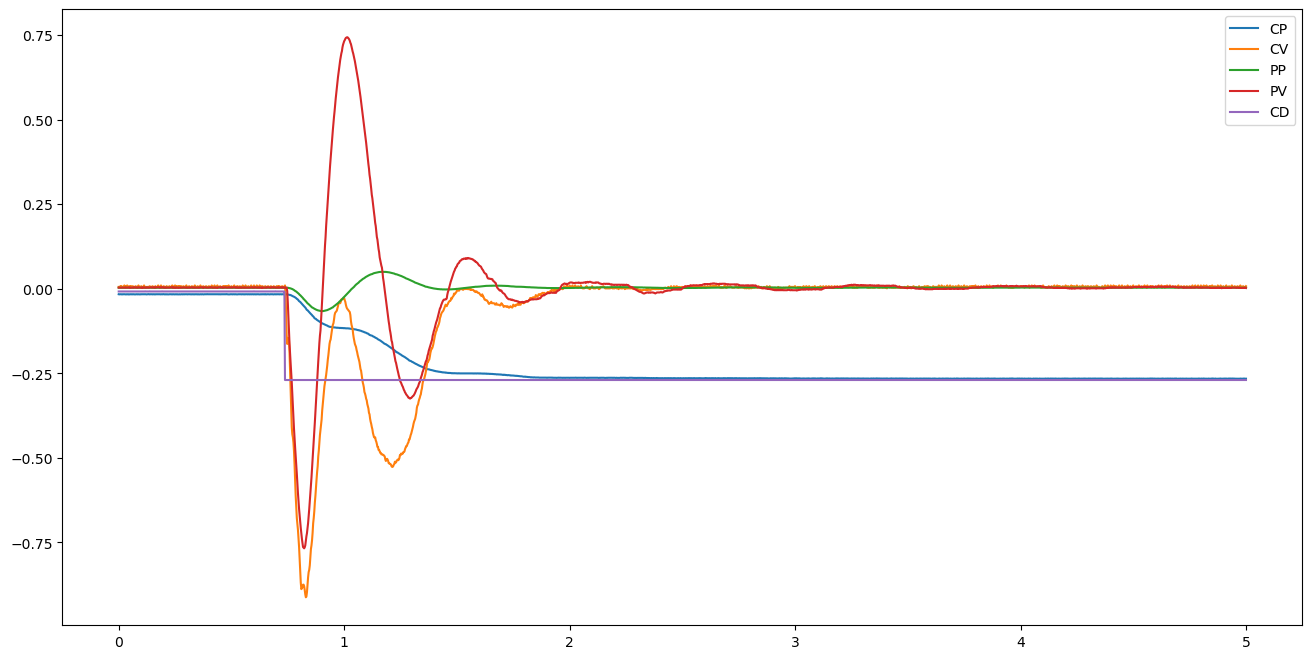

In [13]:
############################## LOAD DATA #######################################
xdata, xdem, tdata =loadlogdata(4,Sc)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

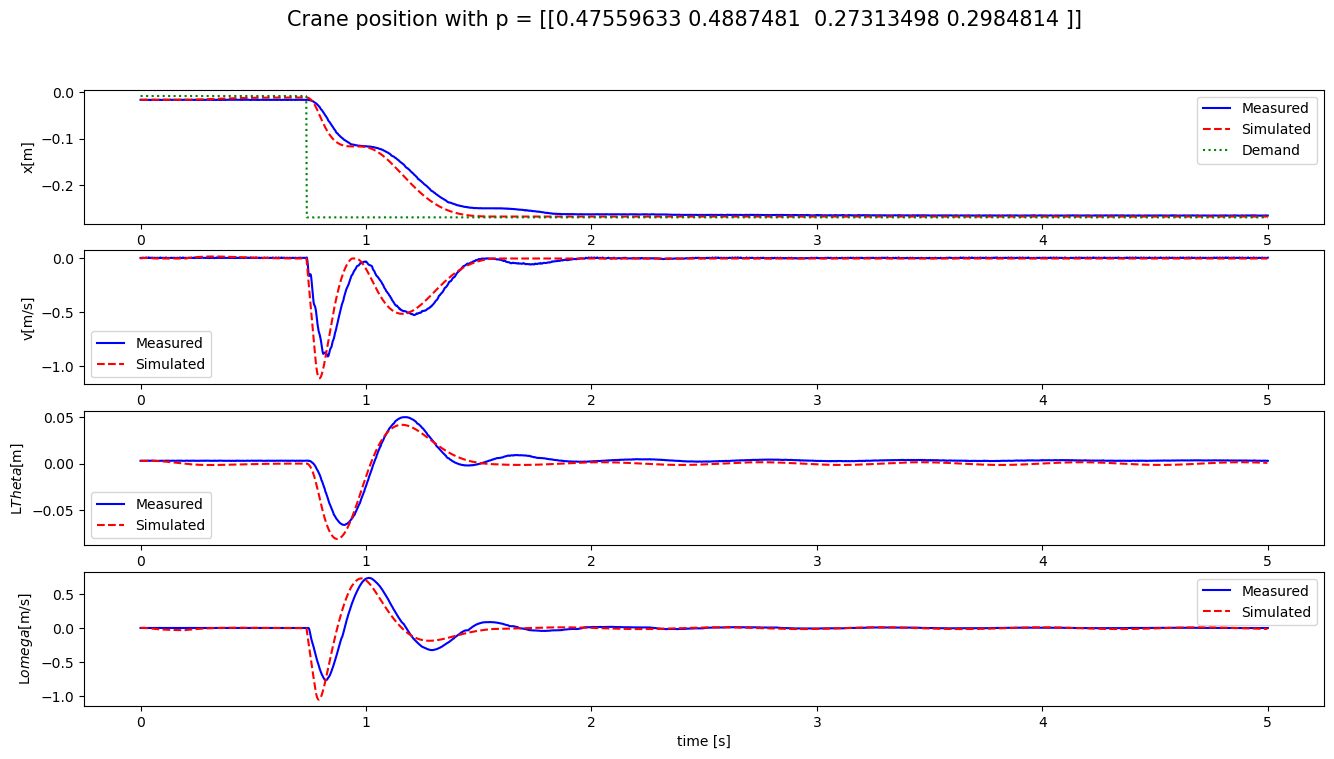

In [39]:
t0 = 0; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)

plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)


# Comment here on the response

...

## 3.5) Variation of $p_2$
With the design 3.4(b) vary $p_2$ until instability just occurs. Log the step response just prior to the onset of oscillations, and record the value of $p_2$. Use the linear model in appendix A to predict the gain $k_2$ at which oscillation will occur, and predict the resonant frequency $\hat \omega$ see section A.5). Compare these with your experimental results (note: $k_2$ = 165 $p_2$ — see A.7(a))

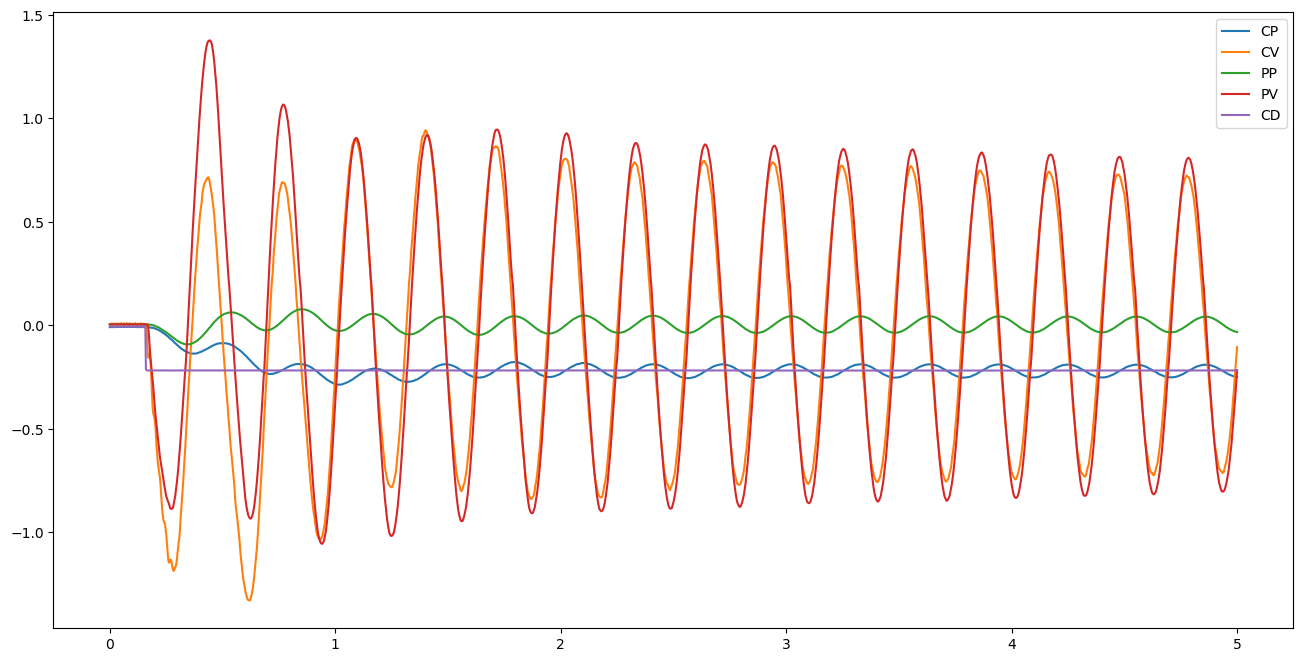

In [40]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(5,Sc)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

In [41]:
P = np.array([[?,?,?,?]])
print("P:", P)
print(np.linalg.eig(Ac-B@P@Cc)[0]) 


SyntaxError: invalid syntax (3575674535.py, line 1)

In [ ]:
t0 = ?; tf = ?# define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_crane(x0,tsim,tdata,xdem,P)

plot_function_crane(t0,tf,tdata,xdata,tsim,x_sim,P)

 # Comment and discuss here section 3.5)
 Value of $p_2$ at the onset of the oscillations: <br>
 Prediicated gain $k_2$: <br>
 Predicted frequency $\hat \omega$: <br>
 
 Compare with actual gain and experimental results: <br>


...

# 4) Pendulum mode

## 4.2) No carriage feedback
Set $p_1 = p_2 = 0$ and $p_3$ and $p_4$ to stabilize the pendulum dynamics, say $p_3 = 0.500$ and $p_4 = 0.110$.  Now hold the pendulum upright and press RESET.  Manually note the force, on the pendulum, required to move the carriage - TAKE DUE CARE. Let go of the pendulum and explain the subsequent behaviour.

In [42]:
P = np.array([[0.0, 0.0, 0.5, 0.11]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.   0.   0.5  0.11]]
[  0.         +0.j           0.         +0.j
 -13.90617284+25.40781422j -13.90617284-25.40781422j]


 # Comment and disucss here section 4.2)


The carriage moves to the desired position while the inverted pendulum stays up.

## 4.3) Pole placement
Using example 2 in section A.5 and the data in section A.7 calculate $p_i$ to place the closed-loop poles at $-\omega_1=-\sqrt{78.5}$, and record your calculated values. Log the response.

In [43]:
P = np.array([[0.25, 0.32, 0.35, 0.28]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.25 0.32 0.35 0.28]]
[-12.33849698+4.90693357j -12.33849698-4.90693357j
  -5.4392808 +2.18151943j  -5.4392808 -2.18151943j]


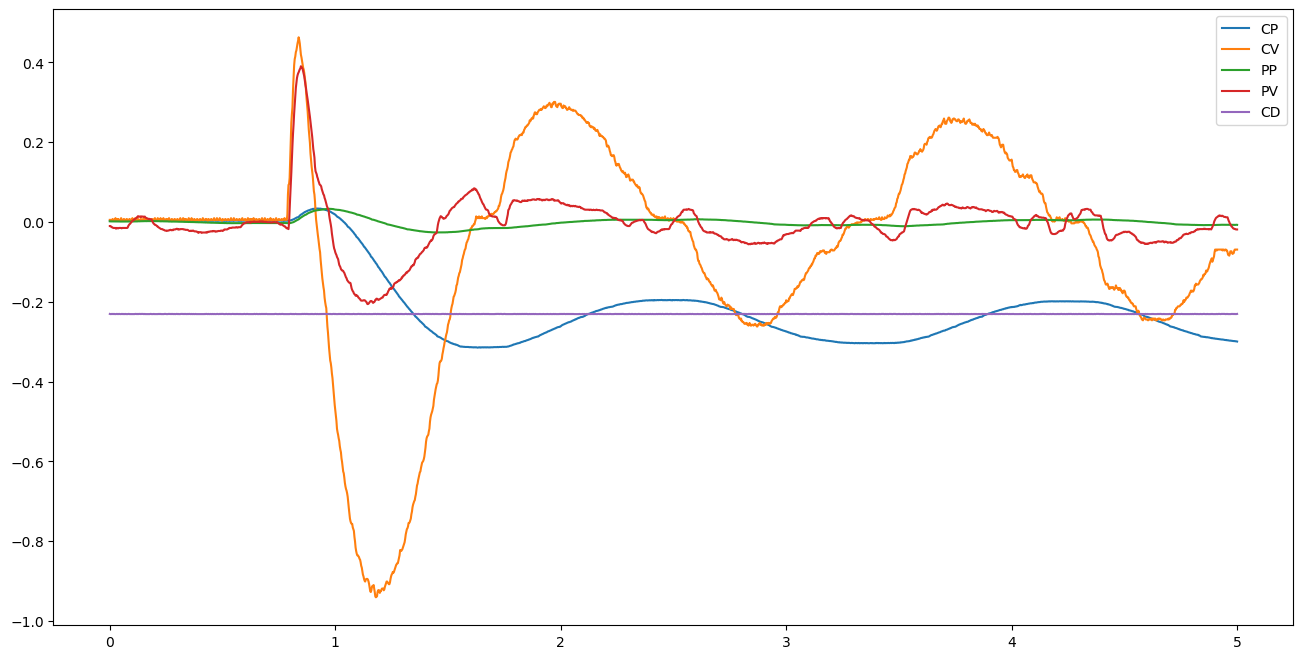

In [44]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(6,Sp)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

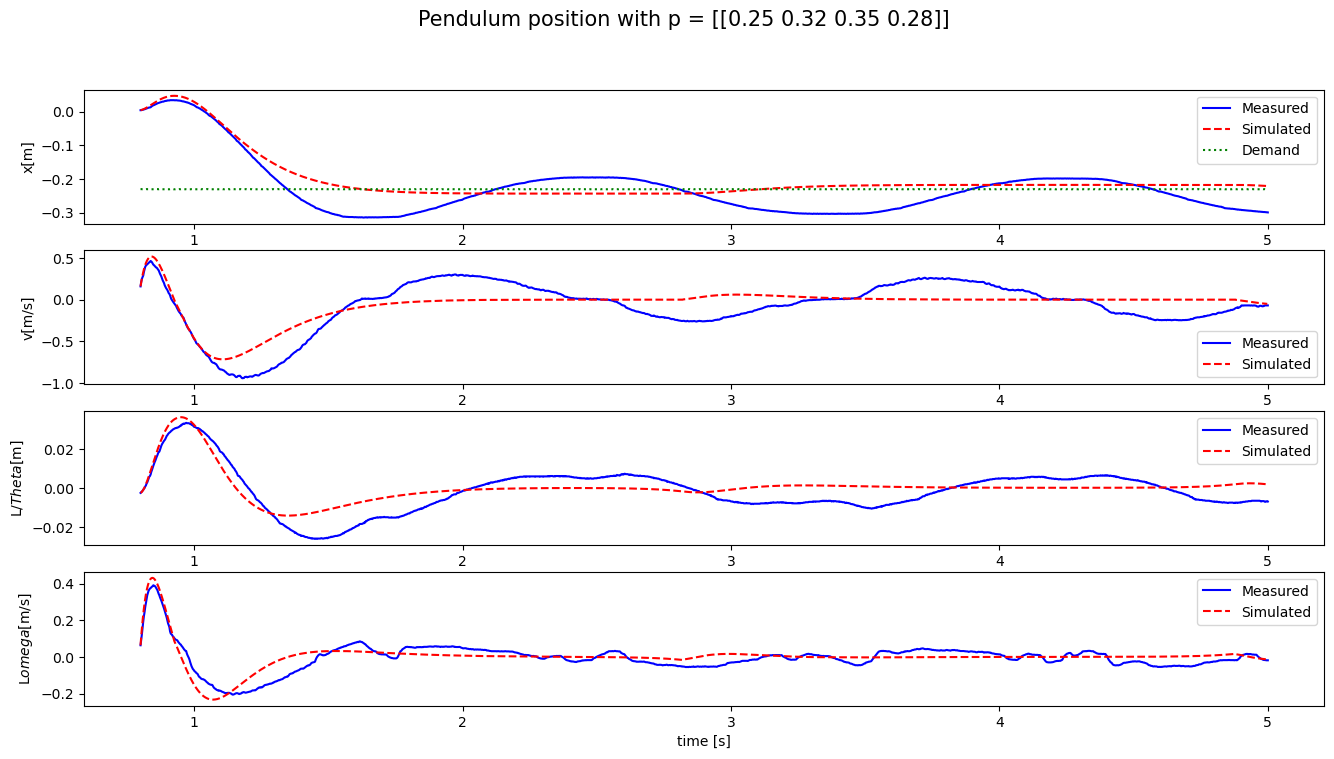

In [47]:
t0 = 0.8; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,P)

plot_function_pendulum(t0,tf,tdata,xdata,tsim,x_sim,P)


## 4.4) Limit Cycles
Set the potentiometers to $p_1 = 0.23 \ \ p_2 = 0.50 \ \ p_3 = 0.63 \ \ p_4 = 0.40$ which should give a reasonably stable response. Now reduce $p_2$ until large oscillations occur (i.e. the carriage nearly hits the end stops). Record your value of $p_2$, and log the response.  Now increase $p_2$ until the system is almost unstable. Record your value of $p_2$, and log the response to a small step.

In [48]:
P = np.array([[0.23, 0.5, 0.63, 0.4]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.23 0.5  0.63 0.4 ]]
[-20.51101586+19.4423977j  -20.51101586-19.4423977j
  -2.52602118 +0.77095105j  -2.52602118 -0.77095105j]


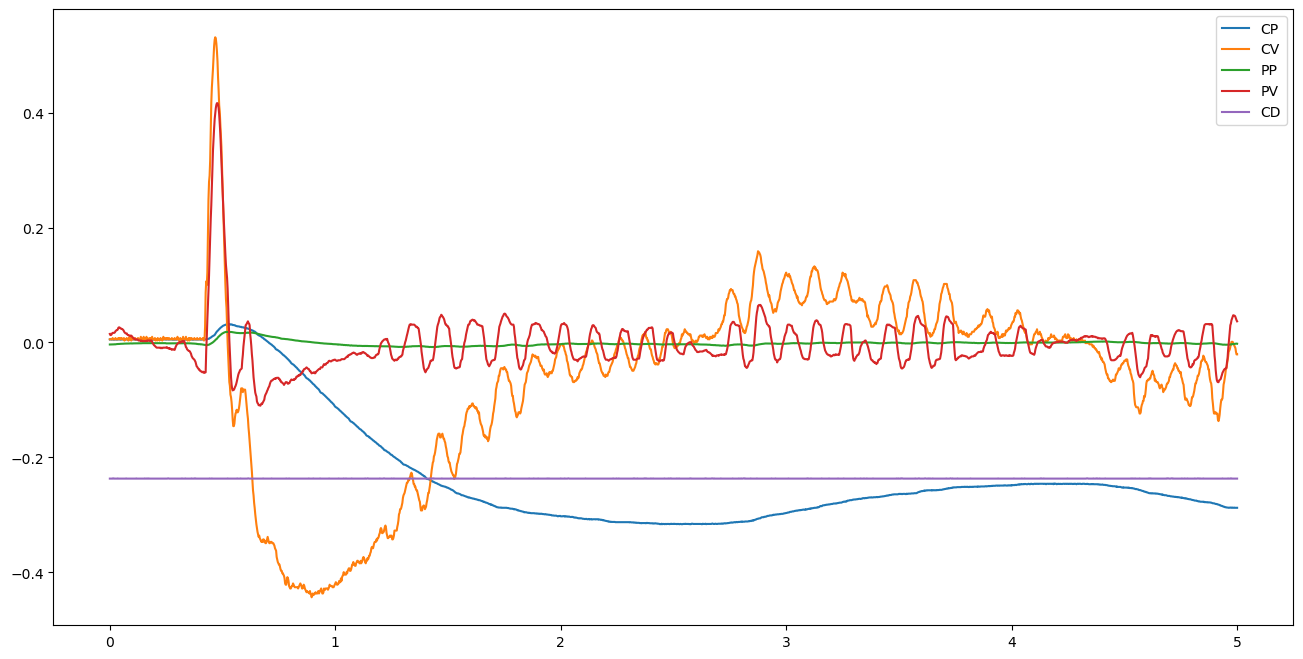

In [49]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(9,Sp)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

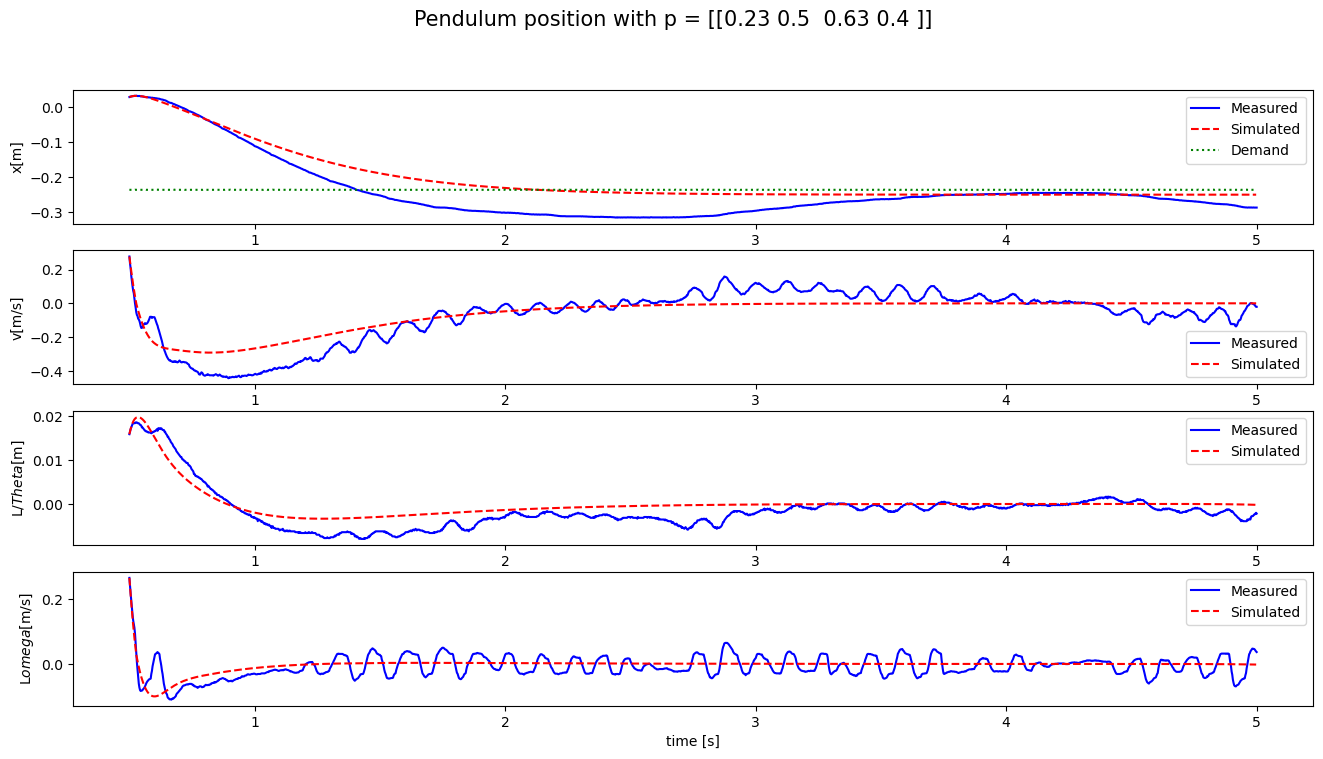

In [51]:
t0 = 0.5; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,P)

plot_function_pendulum(t0,tf,tdata,xdata,tsim,x_sim,P)

# Comment and discuss here section 4.4)

Value of $p_2$ for large oscillations: 0.42

...

Now vary $p_2$

In [52]:
P = np.array([[0.23, 0.42, 0.63, 0.4]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.23 0.42 0.63 0.4 ]]
[-25.38834515+12.36207684j -25.38834515-12.36207684j
  -2.05363016 +1.66411981j  -2.05363016 -1.66411981j]


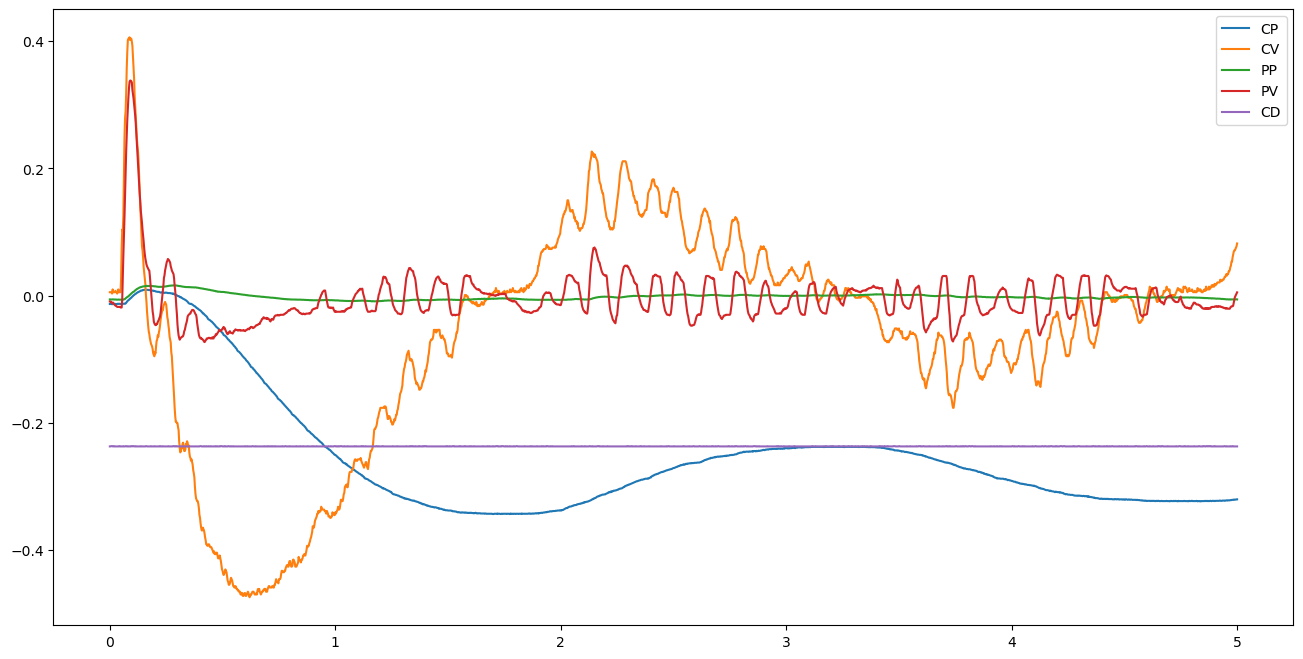

In [54]:
############################## LOAD DATA  #######################################

xdata, xdem, tdata = loadlogdata(7,Sp)
# in the previous line xdem is the external input into the system.

plt.plot(tdata,xdata)
plt.legend(['CP','CV','PP','PV','CD']);

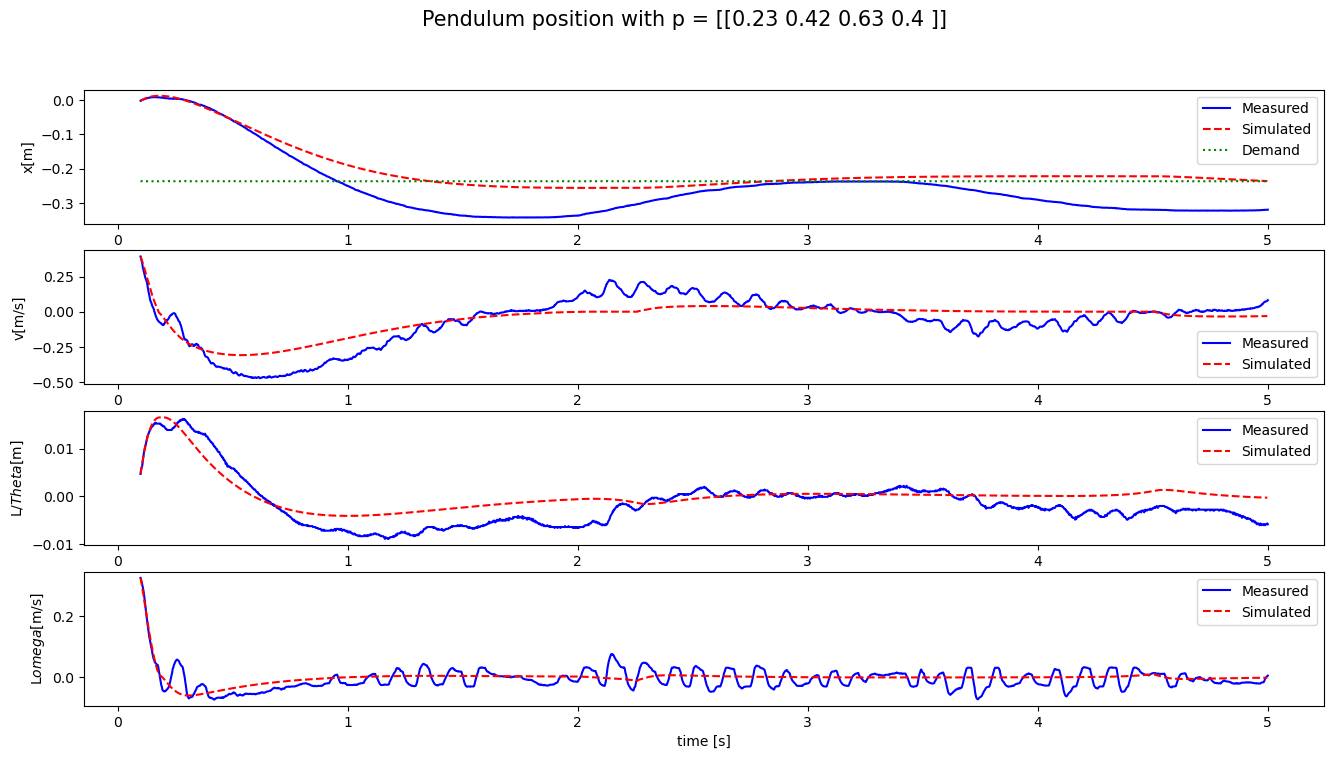

In [56]:
t0 = 0.1; tf = 5 # define the simlation time to be considered

# Set up the initial conditions and time index for the simulation, this uses the recorded data

tsim = np.arange(t0,tf,h_sim)
x0=scipy.interpolate.interp1d(tdata,xdata[:,:4].T)(t0)

x_sim = solver_pendulum(x0,tsim,tdata,xdem,P)

plot_function_pendulum(t0,tf,tdata,xdata,tsim,x_sim,P)

# Comment and discuss here section 4.4) after changing $p_2$

Value of $p_2$ for at the onset of instability: <br>

Describe and explain the beahviour when $p_3=p_4=0$
...

## 4.5) No pendulum feedback
If the design of 4.3) is implemented except with $p_3 = p_4 = 0$ what would happen, and why?

In [57]:
P = np.array([[0.25, 0.32, 0, 0]])
print("P:", P)
print(np.linalg.eig(Ap-B@P@Cp)[0]) 
# Note that the [0] is there to ignore the second output of eig

P: [[0.25 0.32 0.   0.  ]]
[37.96301272  8.51904027 -2.03316228 -9.20938453]


# Comment and discuss here section 4.5


The carriage moves very fast and lost control. The inverted pendulum can not stand.

# <center> Feedback to the student <center>

## Content

### Completeness, quantity of content: Very good | Good | Needs improvement
Has the report covered all aspects of the lab? Has the analysis been carried out thoroughly?

### Correctness, quality of content: Very good | Good | Needs improvement
Is the data correct? Is the analysis of the data correct? Are the conclusions correct?

### Depth of understanding, quality of discussion: Very good | Good | Needs improvement
Does the report show a good technical understanding? Have all the relevant conclusions been drawn?

### Comments

...

## Presentation

### Attention to detail, typesetting and typographical errors: Very good | Good | Needs improvement
Is the report free of typographical errors? Are the figures/tables/references presented professionally?

### Comments

...

# Raw report Mark:
The weighting of comments is not intended to be equal, and the relative importance of criteria may vary between modules. A good report  should  attract 4 marks.

# Penalty for lateness: 
1 mark / week or part week.Please refer to the online information regarding our extension policy.

Marker: <br>
Date: <br>